In [1]:
import cv2
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

# CATEGORIES = ["boxing", "handclapping", "handwaving", "jogging", "running", 
#     "walking"]
CATEGORIES = ["boxing","jogging"]

# Setup parameters for optical flow.
farneback_params = dict(winsize = 20, iterations=1,flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN, levels=1,
                        pyr_scale=0.5, poly_n=5, poly_sigma=1.1, flow=None)



## extract features

Processing category boxing
person23_boxing_d1_uncomp.avi
-- features_current_file:  481
person14_boxing_d1_uncomp.avi
-- features_current_file:  557
person21_boxing_d1_uncomp.avi
-- features_current_file:  364
person20_boxing_d1_uncomp.avi
-- features_current_file:  389
person17_boxing_d1_uncomp.avi
-- features_current_file:  377
person01_boxing_d1_uncomp.avi
-- features_current_file:  359
person19_boxing_d1_uncomp.avi
-- features_current_file:  349
person13_boxing_d1_uncomp.avi
-- features_current_file:  537
person04_boxing_d1_uncomp.avi
-- features_current_file:  327
person11_boxing_d1_uncomp.avi
-- features_current_file:  350
person08_boxing_d1_uncomp.avi
-- features_current_file:  419
person05_boxing_d1_uncomp.avi
-- features_current_file:  437
person24_boxing_d1_uncomp.avi
-- features_current_file:  365
person12_boxing_d1_uncomp.avi
-- features_current_file:  589
features:  14
Processing category jogging
person11_jogging_d1_uncomp.avi
-- features_current_file:  399
person01_joggin

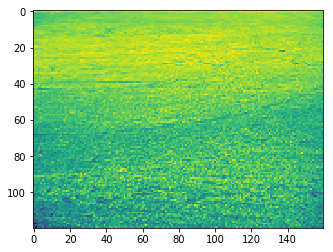

In [2]:
n_processed_files = 0

for category in CATEGORIES:
    print("Processing category %s" % category)

    # Get all files in current category's folder.
#     folder_path = os.path.join("..", "dataset", category)
    folder_path = os.path.join("data", category)
    filenames = os.listdir(folder_path)

    # List to store features. features[i] stores features for the i-th video
    # in current category.
    features = []

    for filename in filenames:
#     for i in range(1):
#         filename = filenames[0]
        print(filename)
        filepath = os.path.join("data",category, filename)
        vid = cv2.VideoCapture(filepath)

        # Store features in current file.
        features_current_file = []

        prev_frame = None

        while vid.isOpened():
            ret, frame = vid.read()
            if not ret:
                break
        

            # Only care about gray scale.
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            

            if prev_frame is not None:
                
#                 print('img-size: ', frame.shape)
                
                plt.imshow(frame)
                
                # Calculate optical flow.
                flows = cv2.calcOpticalFlowFarneback(prev_frame, frame,
                    **farneback_params)

#                 print('flows-size: ', flows.shape)

                feature = []
                for r in range(120):
                    if r % 10 != 0:
                        continue
                    for c in range(160):
                        if c % 10 != 0:
                            continue
                        feature.append(flows[r,c,0])
                        feature.append(flows[r,c,1])
                feature = np.array(feature)
#                 print('feature: ', len(feature))

                features_current_file.append(feature)

            prev_frame = frame
            
        print('-- features_current_file: ', len(features_current_file))
        features.append({
            "filename": filename,
            "category": category,
            "features": features_current_file 
        })

        n_processed_files += 1
#         if n_processed_files % 30 == 0:
#             print("Done %d files" % n_processed_files)

    # Dump data to file.
    
    pickle.dump(features, open("data/optflow_%s.p" % category, "wb"))
    print('features: ',len(features))


## Create dataset-split

In [3]:
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]


In [4]:
train = []
dev = []
test = []

# Store keypoints in training set.
train_keypoints = []

for category in CATEGORIES:
    print("Processing category %s" % category)
    category_features = pickle.load(open("data/optflow_%s.p" % category, "rb"))
#     print(category_features)

    for video in category_features:
        person_id = int(video["filename"].split("_")[0][6:])

        if person_id in TRAIN_PEOPLE_ID:
            train.append(video)

            for frame in video["features"]:
                train_keypoints.append(frame)

        elif person_id in DEV_PEOPLE_ID:
            dev.append(video)
        else:
            test.append(video)

print("Saving train/dev/test set to files")
pickle.dump(train, open("data/train.p", "wb"))
pickle.dump(dev, open("data/dev.p", "wb"))
pickle.dump(test, open("data/test.p", "wb"))

# print("Saving keypoints in training set")
pickle.dump(train_keypoints, open("data/train_keypoints.p", "wb"))


Processing category boxing
Processing category jogging
Saving train/dev/test set to files


In [5]:
clusters = 200
dataset = "data/train_keypoints.p"
print("Loading dataset")
train_features = pickle.load(open(dataset, "rb"))
n_features = len(train_features)

print("Number of feature points to run clustering on: %d" % n_features)



Loading dataset
Number of feature points to run clustering on: 4835


In [12]:
len(train_features[9])

384

## Clusterization

In [14]:
from sklearn.cluster import KMeans
from numpy import size

# Clustering with KMeans.
print("Running KMeans clustering")
kmeans = KMeans(init='k-means++', n_clusters=clusters, n_init=10, n_jobs=2,
    verbose=1)
kmeans.fit(train_features)

# Save trained kmeans object to file.
pickle.dump(kmeans, open("data/cb_%dclusters.p" % clusters, "wb"))

/home/david/entorno1/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


Running KMeans clustering
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 162829.26215200714
start iteration
done sorting
end inner loop
Iteration 1, inertia 157604.81192418252
start iteration
done sorting
end inner loop
Iteration 2, inertia 156229.81307111678
start iteration
done sorting
end inner loop
Iteration 3, inertia 155664.81736859342
start iteration
done sorting
end inner loop
Iteration 4, inertia 155477.72151062646
start iteration
done sorting
end inner loop
Iteration 5, inertia 155408.55972103725
start iteration
done sorting
end inner loop
Iteration 6, inertia 155338.25310155342
start iteration
done sorting
end inner loop
Iteration 7, inertia 155298.5119166526
start iteration
done sorting
end inner loop
Iteration 8, inertia 155260.78074868393
start iteration
done sorting
end inner loop
Iteration 9, inertia 155210.63358108938
start iteration
done sorting
end inner loop
Iteration 10, inertia 155180.96758792098
start iteration
done sorti

Iteration 17, inertia 154347.191454869
start iteration
done sorting
end inner loop
Iteration 18, inertia 154321.01120520677
start iteration
done sorting
end inner loop
Iteration 19, inertia 154294.90133684225
start iteration
done sorting
end inner loop
Iteration 20, inertia 154278.403516135
start iteration
done sorting
end inner loop
Iteration 21, inertia 154267.0265254038
start iteration
done sorting
end inner loop
Iteration 22, inertia 154261.90965582622
start iteration
done sorting
end inner loop
Iteration 23, inertia 154261.38211233338
start iteration
done sorting
end inner loop
Iteration 24, inertia 154261.38211233338
center shift 0.000000e+00 within tolerance 3.937247e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 164048.4159921122
start iteration
done sorting
end inner loop
Iteration 1, inertia 158330.11938068597
start iteration
done sorting
end inner loop
Iteration 2, inertia 156823.57620077237
start iteration
done sorting
end inner

Iteration 3, inertia 154547.94056426466
start iteration
done sorting
end inner loop
Iteration 4, inertia 154255.7277438602
start iteration
done sorting
end inner loop
Iteration 5, inertia 154075.93598782647
start iteration
done sorting
end inner loop
Iteration 6, inertia 153947.75092086737
start iteration
done sorting
end inner loop
Iteration 7, inertia 153860.2605426244
start iteration
done sorting
end inner loop
Iteration 8, inertia 153795.58968131174
start iteration
done sorting
end inner loop
Iteration 9, inertia 153738.07391959088
start iteration
done sorting
end inner loop
Iteration 10, inertia 153653.3918845649
start iteration
done sorting
end inner loop
Iteration 11, inertia 153529.71742597164
start iteration
done sorting
end inner loop
Iteration 12, inertia 153471.8307142538
start iteration
done sorting
end inner loop
Iteration 13, inertia 153448.0233389019
start iteration
done sorting
end inner loop
Iteration 14, inertia 153437.58412536042
start iteration
done sorting
end inn

In [19]:
(kmeans.cluster_centers_)[0]

array([-7.82441403e-05,  1.20003535e-04,  1.12001346e-03,  4.02733316e-03,
        2.68645040e-03,  4.35339088e-03, -1.23920908e-03,  7.00630470e-03,
        3.73550469e-06,  9.07185981e-03,  8.15018106e-04,  3.74637156e-03,
        2.05301880e-03,  2.47879441e-03,  1.19830717e-03,  8.85332517e-04,
        1.32042347e-03,  1.33281954e-03,  1.89293918e-03,  2.88252775e-03,
       -2.02152827e-05,  4.98641141e-03,  1.52301472e-03,  5.38867117e-03,
        2.36902674e-03,  4.86154361e-03,  3.72837853e-03,  4.08810649e-03,
        3.38186434e-03,  4.43188304e-03,  4.81981302e-04,  4.26742202e-03,
        3.52862758e-03, -1.15526603e-03,  2.77074566e-02, -9.50241748e-03,
        2.71296998e-02, -1.91018525e-02,  2.23182918e-02, -9.76677162e-03,
        1.62581864e-02, -7.96156968e-03,  1.92423807e-02, -3.50918739e-03,
        2.24925027e-02, -2.52413117e-02, -1.68215436e-02, -7.35943468e-02,
        7.34320508e-03, -4.87980216e-02,  1.93276225e-02,  1.88754474e-02,
        5.58257065e-03,  

In [20]:
dataset  = "data/train.p"
codebook_file = "data/cb_200clusters.p"
# Load clusters.
codebook = pickle.load(open(codebook_file, "rb"))
clusters = codebook.cluster_centers_

# Load dataset.
dataset = pickle.load(open(dataset, "rb"))

    
n_videos = len(dataset)
bow = np.zeros((n_videos, clusters.shape[0]), dtype=np.float)
print(bow.shape)

(10, 200)


In [25]:
from scipy.cluster.vq import vq

# Make bow vectors for all videos.
video_index = 0

for video in dataset:
    visual_word_ids = vq(video["features"], clusters)[0]
    print(len(visual_word_ids))
    for word_id in visual_word_ids:
        bow[video_index, word_id] += 1
    video_index += 1

bow.shape, bow

557
377
537
350
589
399
389
659
479
499


((10, 200), array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [190.,   0.,   0., ...,   0.,   0.,   0.],
        [  4.,   0.,   0., ...,   0.,  46.,   0.],
        ...,
        [  0.,   0.,   4., ...,   0.,   0.,   4.],
        [  0.,   2.,   0., ...,   0.,   0.,   0.],
        [  0.,   8.,   0., ...,   0.,   0.,   0.]]))

In [26]:
# Check whether to use TF-IDF weighting.
tfidf = False
if tfidf:
    print("Applying TF-IDF weighting")
    freq = np.sum((bow > 0) * 1, axis = 0)
    idf = np.log((n_videos + 1) / (freq + 1))
    bow = bow * idf

# Replace features in dataset with the bow vector we've computed.
video_index = 0
for i in range(len(dataset)):

    dataset[i]["features"] = bow[video_index]
    video_index += 1

    if (i + 1) % 50 == 0:
        print("Processed %d/%d videos" % (i + 1, len(dataset)))


In [28]:
dataset[0]

{'filename': 'person14_boxing_d1_uncomp.avi',
 'category': 'boxing',
 'features': array([  0.,   0.,   0.,   0.,   0.,  50.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  96.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,  76.,   0.,   0.,  66.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  86.,   0.,   0.,  16.,
          0.,   0.,   0.,   0.,   0.,   0.,   0., 154.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  80.,   0.,
          0.,   0.,   0.,   0.,  20.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  74.,   0.,   0.,

## train

In [29]:
from sklearn.svm import SVC

def make_dataset(dataset):
    X = []
    Y = []

    for video in dataset:
        X.append(video["features"])
        Y.append(video["category"])
    return X,Y
        
X, Y = make_dataset(dataset)


In [34]:
len(X)

10

In [36]:
# Train SVM and save to file.
clf = SVC(C=1, kernel="linear", verbose=True)
clf.fit(X, Y)

[LibSVM]

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=True)